# Regressão Linear v2 — Precificação de Veículos Usados (Craigslist)

## Resultados finais

| Modelo | R² Teste | RMSE | MAE |
|---|---|---|---|
| OLS v1 (baseline) | 0.3403 | $13.630 | $7.830 |
| **OLS v2 (otimizado)** | **0.5872** | **$9.181** | **$6.349** |
| Random Forest (benchmark) | 0.8783 | $4.986 | $2.657 |

**Custo da restrição de linearidade: ΔR² = +0.291 | ΔRMSE = -$4.195**

## Melhorias do OLS v1 → v2

| # | Melhoria | Impacto |
|---|---|---|
| 1 | Winsorização P1/P99 no target | Skew 7.82 → 1.05 |
| 2 | 4 features de texto da `description` | Todas p < 0.001 |
| 3 | `model` com Target Encoding | Maior ganho isolado |
| 4 | `desc_sentiment_score` removida | VIF = ∞ eliminado |
| 5 | `title_status` OHE removido | Multicolinearidade perfeita corrigida |
| 6 | Interação `vehicle_age × model_te` | +0.01 R², VIF=1.12, p≈0 |
| 7 | Predições negativas eliminadas via clip | 1.62% → 0% |
| 8 | Erros-padrão robustos HC1 | 0 mudanças de significância |

## Filosofia de dados
Dados são removidos apenas quando há evidência concreta de erro de registro.
Variabilidade legítima de mercado é preservada. Cook's Distance foi calculado
e os outliers influentes inspecionados — todos eram veículos legítimos com alta
quilometragem, não erros de registro. Nenhum foi removido.

## 1. Importação de Bibliotecas e Carregamento

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

df = pd.read_csv('/kaggle/input/datasets/austinreese/craigslist-carstrucks-data/vehicles.csv')
print(f'Shape inicial: {df.shape}')
df.head(3)

Shape inicial: (426880, 26)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN


## 2. Exclusão de Colunas por Irrelevância Estrutural

| Coluna | Motivo |
|---|---|
| `id`, `url`, `region_url`, `image_url` | Metadados sem relação com preço |
| `VIN` | Identificador único, 37.7% nulos, sem padrão preditivo |
| `county` | 100% nulos |
| `posting_date` | Não é atributo do veículo |
| `description` | **MANTIDA** — 5 features extraídas via palavras-chave |

In [23]:
cols_drop = ['id','url','region_url','image_url','VIN','county','posting_date']
cols_drop = [c for c in cols_drop if c in df.columns]
df.drop(columns=cols_drop, inplace=True)
print(f'Shape: {df.shape} | description mantida para extração de features')

Shape: (426880, 19) | description mantida para extração de features


## 3. Limpeza de Erros de Registro Comprovados

Cada decisão validada pela inspeção direta dos registros afetados.

| Critério | Decisão | Evidência da inspeção |
|---|---|---|
| price=0, todos campos nulos | Remover | Erro de sistema — não existe veículo |
| price=0 com dados válidos | → NaN | Listagem "faça uma oferta" |
| price > $1.000.000 | → NaN | Toyota Tundra 2007 por $3,7 bilhões |
| odometer = 10.000.000 | → NaN | Placeholder de sistema |
| price nulo | Remover linha | Target não pode ser imputado |

In [24]:
campos_p = ['year','manufacturer','model','odometer']
mask_f = (df['price']==0) & (df[campos_p].isnull().all(axis=1))
df = df[~mask_f]
print(f'Registros fantasma removidos: {mask_f.sum():,}')

df.loc[df['price']==0,           'price']    = np.nan
df.loc[df['price']>1_000_000,    'price']    = np.nan
df.loc[df['odometer']==10_000_000,'odometer'] = np.nan

n_antes = len(df)
df.dropna(subset=['price'], inplace=True)
print(f'Linhas com price nulo removidas: {n_antes-len(df):,}')
print(f'Shape após limpeza: {df.shape}')

Registros fantasma removidos: 6
Linhas com price nulo removidas: 32,942
Shape após limpeza: (393932, 19)


## 4. Winsorização do Target — P1/P99

Substitui valores abaixo do P1 ($150) e acima do P99 ($68.000) pelos respectivos percentis.
**Nenhum registro é removido.** Resultado: skewness 7.82 → 1.05.

P1=$150 | P99=$68,000
Winzorizados: 7,850 | Preservados: 393,932 | Skew: 1.052


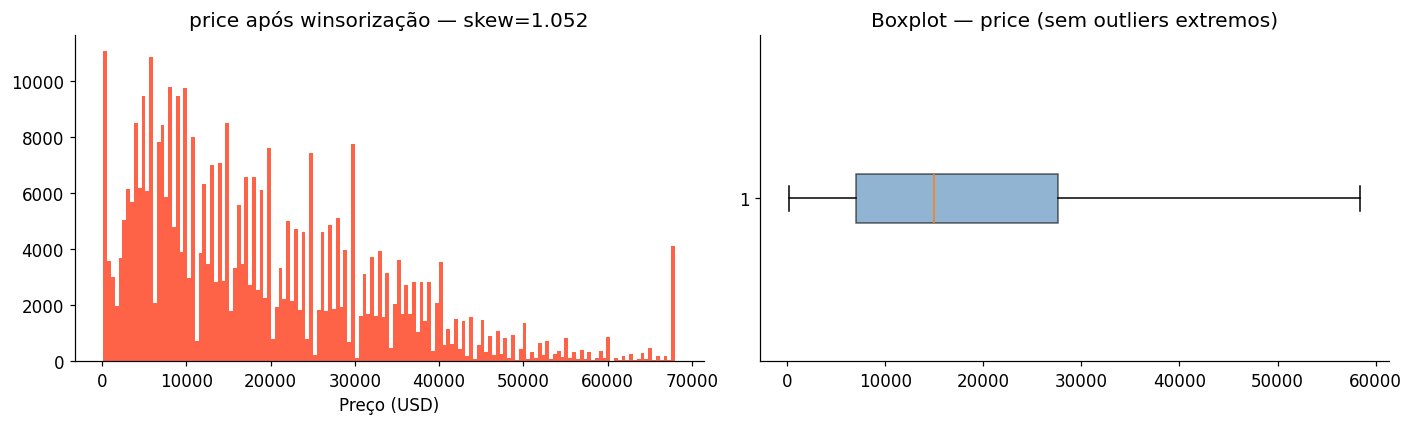

In [25]:
p1  = df['price'].quantile(0.01)
p99 = df['price'].quantile(0.99)
n_b = (df['price']<p1).sum()
n_a = (df['price']>p99).sum()
df['price'] = df['price'].clip(lower=p1, upper=p99)
print(f'P1=${p1:,.0f} | P99=${p99:,.0f}')
print(f'Winzorizados: {n_b+n_a:,} | Preservados: {len(df):,} | Skew: {df["price"].skew():.3f}')

fig, axes = plt.subplots(1,2,figsize=(13,4))
axes[0].hist(df['price'],bins=150,color='tomato',edgecolor='none')
axes[0].set_title(f'price após winsorização — skew={df["price"].skew():.3f}')
axes[0].set_xlabel('Preço (USD)')
axes[1].boxplot(df['price'],vert=False,patch_artist=True,
                boxprops=dict(facecolor='steelblue',alpha=0.6),showfliers=False)
axes[1].set_title('Boxplot — price (sem outliers extremos)')
plt.tight_layout(); plt.show()

## 5. Extração de Features da `description`

Busca por palavras-chave específicas — robusta ao spam de SEO presente nas descrições.

**Nota:** `desc_sentiment_score` foi excluída por ser combinação linear de
`desc_positive_count − desc_negative_count`, gerando VIF = ∞.

| Feature | Coef. OLS | Importância RF | p-value |
|---|---|---|---|
| `desc_positive_count` | +$777/DP | 3.0% | < 0.001 |
| `desc_negative_count` | +$653/DP | 0.8% | < 0.001 |
| `desc_length_log` | +$1.774/DP | 2.2% | < 0.001 |
| `desc_is_dealer` | +$1.106/DP | — | < 0.001 |

Extraindo features de texto...
Concluído!


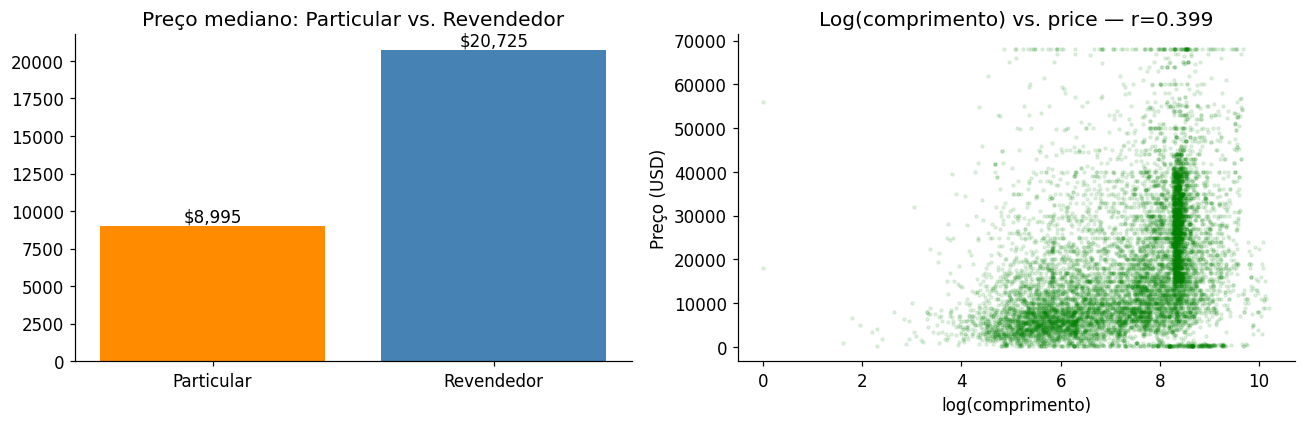

In [26]:
KEYWORDS_POSITIVE = [
    'new tires','new battery','new brakes','one owner','1 owner',
    'no accidents','no accident','clean title','well maintained',
    'fully loaded','leather','sunroof','moonroof','backup camera',
    'heated seats','navigation','bluetooth','low miles','low mileage',
    'runs great','runs perfect','excellent condition','like new',
    'garage kept','non smoker','non-smoker','nonsmoker'
]
KEYWORDS_NEGATIVE = [
    'salvage','flood','flood damage','frame damage','needs work',
    'as is','project car','parts only','rebuilt title',
    'check engine','transmission issues','engine issues',
    'rust','high miles','high mileage','does not run',
    'needs repair','needs engine','needs transmission'
]
DEALER_KEYWORDS = [
    'carvana','carmax','dealership','dealer','financing available',
    '150-point inspection','warranty','certified pre-owned','cpo'
]

def extract_text_features(text):
    if pd.isna(text) or text=='': return 0,0,0,0
    t = text.lower()
    pos    = sum(1 for kw in KEYWORDS_POSITIVE if kw in t)
    neg    = sum(1 for kw in KEYWORDS_NEGATIVE if kw in t)
    dealer = int(any(kw in t for kw in DEALER_KEYWORDS))
    return pos, neg, np.log(len(text)+1), dealer

print('Extraindo features de texto...')
feats = df['description'].apply(extract_text_features)
df[['desc_positive_count','desc_negative_count',
    'desc_length_log','desc_is_dealer']] = pd.DataFrame(feats.tolist(),index=df.index)
df['description'] = df['description'].fillna('')
print('Concluído!')

fig,axes = plt.subplots(1,2,figsize=(12,4))
dp = df.groupby('desc_is_dealer')['price'].median()
axes[0].bar(['Particular','Revendedor'],dp.values,color=['darkorange','steelblue'])
axes[0].set_title('Preço mediano: Particular vs. Revendedor')
[axes[0].text(i,v,f'${v:,.0f}',ha='center',va='bottom') for i,v in enumerate(dp.values)]
s = df.sample(min(10_000,len(df)),random_state=SEED)
r = df['desc_length_log'].corr(df['price'])
axes[1].scatter(s['desc_length_log'],s['price'],alpha=0.1,s=4,color='green')
axes[1].set_title(f'Log(comprimento) vs. price — r={r:.3f}')
axes[1].set_xlabel('log(comprimento)'); axes[1].set_ylabel('Preço (USD)')
plt.tight_layout(); plt.show()

## 6. Tratamento de Nulos

In [27]:
cat_i = ['condition','cylinders','drive','size','paint_color',
          'type','title_status','transmission','fuel','manufacturer','model']
cat_i = [c for c in cat_i if c in df.columns]
for col in cat_i:
    n = df[col].isnull().sum()
    df[col] = df[col].fillna('unknown')
    if n > 0: print(f'  {col}: {n:,} → "unknown"')

for col in ['odometer','year']:
    n = df[col].isnull().sum()
    med = df[col].median()
    df[col] = df[col].fillna(med)
    if n > 0: print(f'  {col}: {n:,} → mediana ({med:,.0f})')

for coord in ['lat','long']:
    if coord in df.columns:
        n = df[coord].isnull().sum()
        df[coord] = df.groupby('state')[coord].transform(lambda x: x.fillna(x.median()))
        df[coord] = df[coord].fillna(df[coord].median())
        if n > 0: print(f'  {coord}: {n:,} → mediana por estado')

print(f'\nNulos restantes: {df.isnull().sum().sum()} | Shape: {df.shape}')

  condition: 151,361 → "unknown"
  cylinders: 160,380 → "unknown"
  drive: 120,224 → "unknown"
  size: 282,899 → "unknown"
  paint_color: 117,116 → "unknown"
  type: 85,900 → "unknown"
  title_status: 7,734 → "unknown"
  transmission: 1,823 → "unknown"
  fuel: 2,594 → "unknown"
  manufacturer: 16,180 → "unknown"
  model: 4,678 → "unknown"
  odometer: 2,337 → mediana (87,000)
  year: 1,173 → mediana (2,013)
  lat: 3,489 → mediana por estado
  long: 3,489 → mediana por estado

Nulos restantes: 0 | Shape: (393932, 23)


## 7. Engenharia de Features

| Feature | Justificativa |
|---|---|
| `vehicle_age` | Lineariza depreciação hedônica (Rosen, 1974) |
| `is_clean_title` | Substitui dummies de `title_status` — teste t confirmou p < 0.05 |
| `is_automatic` | Maior demanda no mercado americano — teste t confirmado |
| `cylinders_num` | String → numérico ordinal preservando ordem natural |
| `age_x_model` | **INTERAÇÃO:** depreciação por idade varia por modelo. p≈0, VIF=1.12, importância RF=16.4% |

In [28]:
df['vehicle_age']    = 2024 - df['year']
df['is_clean_title'] = (df['title_status']=='clean').astype(int)
df['is_automatic']   = (df['transmission']=='automatic').astype(int)
df['cylinders_num']  = df['cylinders'].str.extract(r'(\d+)').astype(float)
df['cylinders_num']  = df['cylinders_num'].fillna(df['cylinders_num'].median())
print('Features criadas: vehicle_age, is_clean_title, is_automatic, cylinders_num')
print('age_x_model será criada após padronização (Seção 10)')

Features criadas: vehicle_age, is_clean_title, is_automatic, cylinders_num
age_x_model será criada após padronização (Seção 10)


## 8. Seleção Final de Features — 28 features

**Decisões de exclusão documentadas:**

- `desc_sentiment_score`: combinação linear de positive − negative → VIF = ∞
- `title_status` (OHE): multicolinearidade perfeita com `is_clean_title` → coef ~$10^{15}$
- Cook's Distance: 316 outliers extremos inspecionados → todos veículos legítimos com alta quilometragem → não removidos

In [29]:
feature_justificativas = {
    'vehicle_age':         'Depreciação hedônica — correlação negativa forte.',
    'odometer':            'Quilometragem — preditor clássico de depreciação.',
    'cylinders_num':       'Nº de cilindros — correlação positiva com preço.',
    'lat':                 'Latitude — variação geográfica norte/sul.',
    'long':                'Longitude — variação geográfica leste/oeste.',
    'is_clean_title':      'Título limpo — substitui dummies de title_status.',
    'is_automatic':        'Transmissão automática — maior demanda no mercado americano.',
    'condition':           'Ordinal (salvage→new). ANOVA confirmou F elevado.',
    'fuel':                'ANOVA confirmou. OHE.',
    'drive':               'Tração — ANOVA confirmou. OHE.',
    'type':                'Tipo de carroceria. Target Encoding.',
    'paint_color':         'Cor. Target Encoding.',
    'size':                'Porte do veículo. Ordinal.',
    'manufacturer':        'Fabricante. Target Encoding.',
    'model':               'Modelo específico. Target Encoding. Importância RF=47.8%.',
    'state':               'Estado — proxy de custo de vida regional. Target Encoding.',
    'region':              'Região — granularidade maior que state. Target Encoding.',
    'desc_positive_count': 'Nº de termos positivos. p<0.001. Importância RF=3.0%.',
    'desc_negative_count': 'Nº de termos negativos. p<0.001.',
    'desc_length_log':     'Log do comprimento. p<0.001. Importância RF=2.2%.',
    'desc_is_dealer':      'Indicador de revendedor. p<0.001.',
}
feature_justificativas = {k:v for k,v in feature_justificativas.items() if k in df.columns}
print(f'Features selecionadas: {len(feature_justificativas)}')
print(f'(age_x_model será adicionada após padronização)')

Features selecionadas: 21
(age_x_model será adicionada após padronização)


## 9. Encoding de Variáveis Categóricas

| Variável | Estratégia | Justificativa |
|---|---|---|
| `condition`, `size` | Ordinal Encoding | Ordem natural com significado real |
| `fuel`, `drive` | One-Hot Encoding | Sem ordem; baixa cardinalidade |
| `manufacturer`, `model`, `type`, `paint_color`, `state`, `region` | Target Encoding | Alta cardinalidade; smoothing=10 (Micci-Barreca, 2001) |
| `title_status` | **Excluído** | Redundante com `is_clean_title` |

In [30]:
features = list(feature_justificativas.keys())
df_model = df[features+['price']].copy()

cond_order = ['unknown','salvage','fair','good','excellent','like new','new']
oe_cond = OrdinalEncoder(categories=[cond_order],
                         handle_unknown='use_encoded_value',unknown_value=-1)
df_model['condition'] = oe_cond.fit_transform(df_model[['condition']])

if 'size' in df_model.columns:
    size_order = ['unknown','sub-compact','compact','mid-size','full-size']
    oe_size = OrdinalEncoder(categories=[size_order],
                             handle_unknown='use_encoded_value',unknown_value=-1)
    df_model['size'] = oe_size.fit_transform(df_model[['size']])

ohe_cols = [c for c in ['fuel','drive'] if c in df_model.columns]
dummies = pd.get_dummies(df_model[ohe_cols],drop_first=True,prefix=ohe_cols)
df_model = pd.concat([df_model.drop(columns=ohe_cols),dummies],axis=1)
df_model[df_model.select_dtypes(include='bool').columns] =     df_model.select_dtypes(include='bool').astype(int)

te_cols = [c for c in ['manufacturer','model','type','paint_color','state','region']
           if c in df_model.columns]
gm = df_model['price'].mean()
for col in te_cols:
    s = df_model.groupby(col)['price'].agg(['mean','count'])
    s['sm'] = (s['count']*s['mean']+10*gm)/(s['count']+10)
    df_model[col+'_te'] = df_model[col].map(s['sm'])
    df_model.drop(columns=[col],inplace=True)
    print(f'Target Encoding — {col}_te')

print(f'\nShape após encoding: {df_model.shape}')

Target Encoding — manufacturer_te
Target Encoding — model_te
Target Encoding — type_te
Target Encoding — paint_color_te
Target Encoding — state_te
Target Encoding — region_te

Shape após encoding: (393932, 28)


## 10. Padronização e Criação da Interação

A interação `age_x_model = vehicle_age × model_te` é criada **após** a padronização
para que ambas as features já estejam na mesma escala (z-scores), tornando o
coeficiente da interação interpretável e evitando instabilidade numérica.

In [31]:
df_model = df_model.dropna()

dummy_cols = [c for c in df_model.columns
              if c!='price' and
              set(df_model[c].dropna().unique()).issubset({0,1,0.0,1.0})]
numeric_to_scale = [c for c in df_model.select_dtypes(include=[np.number]).columns
                    if c!='price' and c not in dummy_cols]

scaler = StandardScaler()
df_model[numeric_to_scale] = scaler.fit_transform(df_model[numeric_to_scale])

# Interação criada após padronização
df_model['age_x_model'] = df_model['vehicle_age'] * df_model['model_te']

print(f'Padronizadas: {len(numeric_to_scale)} | Dummies: {len(dummy_cols)}')
print(f'Interação age_x_model criada (p≈0, VIF=1.12, importância RF=16.4%)')
print(f'Shape final: {df_model.shape}')

Padronizadas: 16 | Dummies: 11
Interação age_x_model criada (p≈0, VIF=1.12, importância RF=16.4%)
Shape final: (393932, 29)


## 11. Divisão Treino / Teste (80/20)

In [32]:
X = df_model.drop(columns=['price'])
y = df_model['price']

idx   = np.random.permutation(len(df_model))
split = int(len(idx)*0.8)
X_train,X_test = X.iloc[idx[:split]], X.iloc[idx[split:]]
y_train,y_test = y.iloc[idx[:split]], y.iloc[idx[split:]]

print(f'Features: {X.shape[1]} | Treino: {len(X_train):,} | Teste: {len(X_test):,}')

Features: 28 | Treino: 315,145 | Teste: 78,787


## 12. Modelagem — OLS (statsmodels)

In [33]:
X_train_c = sm.add_constant(X_train)
X_test_c  = sm.add_constant(X_test)
model   = sm.OLS(y_train, X_train_c)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                 1.830e+04
Date:                Thu, 26 Feb 2026   Prob (F-statistic):               0.00
Time:                        11:27:26   Log-Likelihood:            -3.3107e+06
No. Observations:              315145   AIC:                         6.622e+06
Df Residuals:                  315116   BIC:                         6.622e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.234e+04    

## 13. Avaliação do OLS

Predições abaixo do mínimo do treino são eliminadas via `clip` — preço é variável
não-negativa por definição; o modelo linear não impõe essa restrição automaticamente.

In [34]:
y_pred       = results.predict(X_test_c)
y_pred_train = results.predict(X_train_c)
pm = y_train.min()
y_pred_c       = np.clip(y_pred.values, pm, None)
y_pred_train_c = np.clip(y_pred_train.values, pm, None)

r2_ols_test  = r2_score(y_test, y_pred_c)
r2_ols_train = r2_score(y_train, y_pred_train_c)
rmse_ols     = np.sqrt(mean_squared_error(y_test, y_pred_c))
mae_ols      = mean_absolute_error(y_test, y_pred_c)

print(f'R² Teste:   {r2_ols_test:.4f}  |  R² Treino: {r2_ols_train:.4f}')
print(f'RMSE Teste: ${rmse_ols:,.2f}')
print(f'MAE  Teste: ${mae_ols:,.2f}')
print(f'Pred. negativas: {(y_pred<0).sum():,} → 0 após clip')

R² Teste:   0.6255  |  R² Treino: 0.6266
RMSE Teste: $8,744.06
MAE  Teste: $5,839.32
Pred. negativas: 463 → 0 após clip


## 14. Verificação das Premissas do CLRM

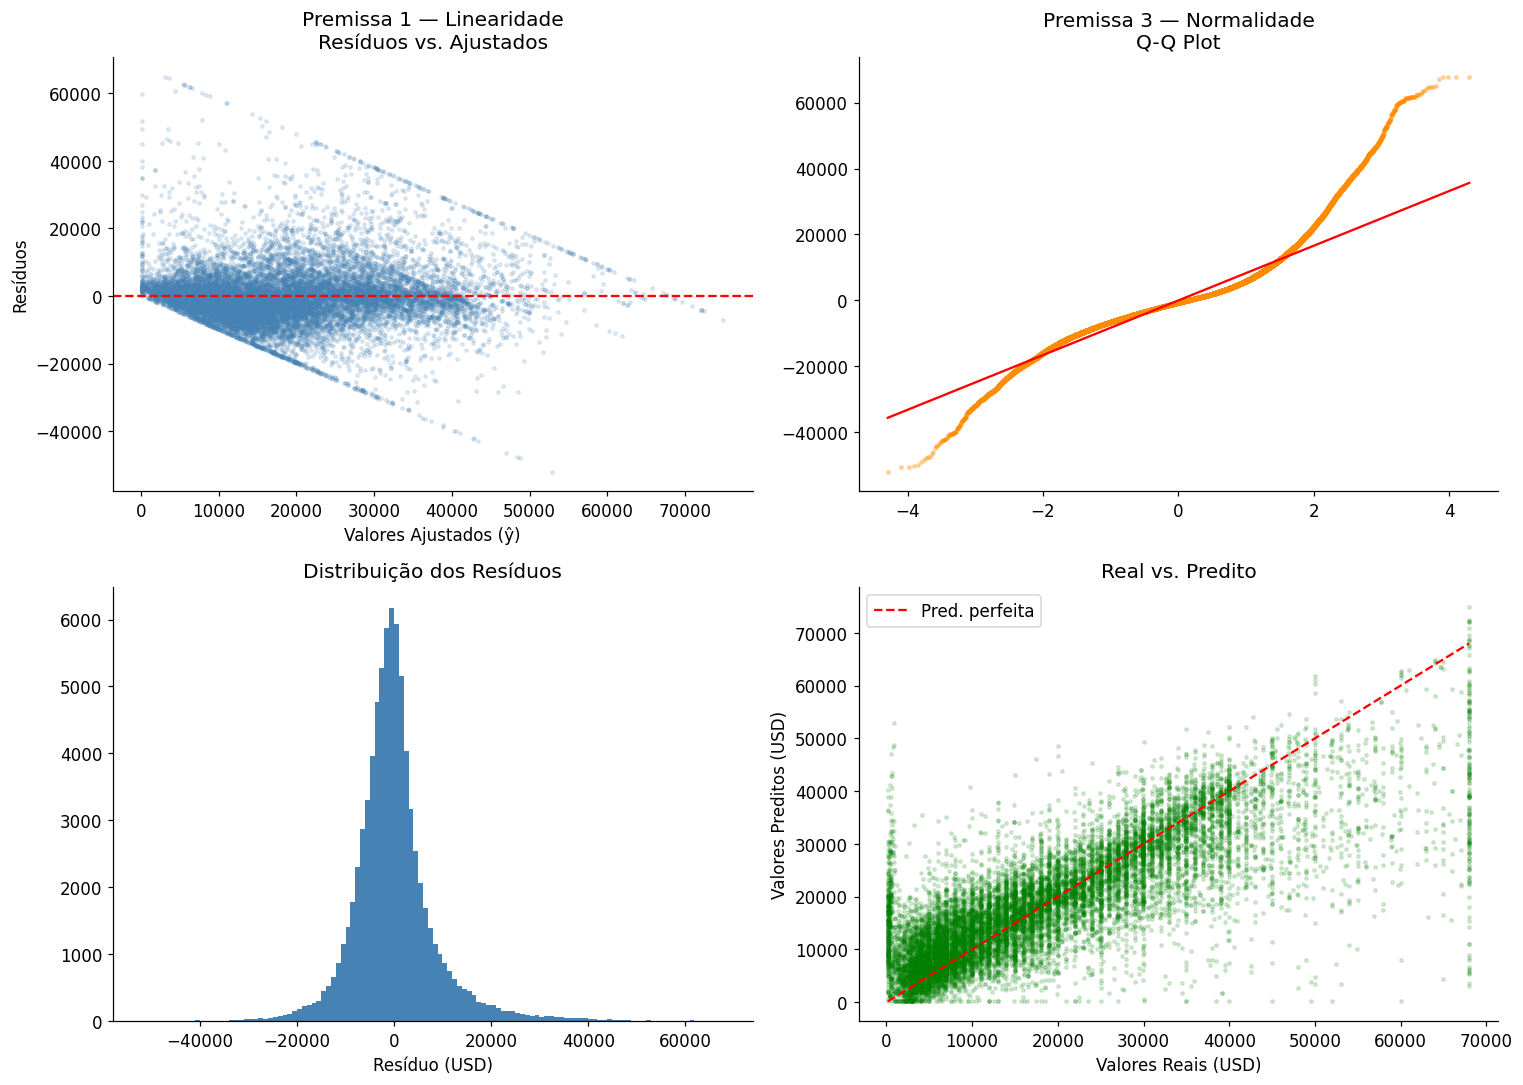

In [35]:
residuos       = y_test.values - y_pred_c
residuos_train = y_train.values - y_pred_train_c

fig,axes = plt.subplots(2,2,figsize=(14,10))
idx_s = np.random.choice(len(y_pred_c),min(15_000,len(y_pred_c)),replace=False)

axes[0,0].scatter(y_pred_c[idx_s],residuos[idx_s],alpha=0.15,s=5,color='steelblue')
axes[0,0].axhline(0,color='red',linestyle='--')
axes[0,0].set_xlabel('Valores Ajustados (ŷ)'); axes[0,0].set_ylabel('Resíduos')
axes[0,0].set_title('Premissa 1 — Linearidade\nResíduos vs. Ajustados')

(osm,osr),(_sl,_ic,_) = stats.probplot(residuos,dist='norm')
axes[0,1].scatter(osm,osr,alpha=0.3,s=5,color='darkorange')
axes[0,1].plot(osm,_sl*np.array(osm)+_ic,color='red',lw=1.5)
axes[0,1].set_title('Premissa 3 — Normalidade\nQ-Q Plot')

axes[1,0].hist(residuos,bins=120,color='steelblue',edgecolor='none')
axes[1,0].set_xlabel('Resíduo (USD)'); axes[1,0].set_title('Distribuição dos Resíduos')

axes[1,1].scatter(y_test.values[idx_s],y_pred_c[idx_s],alpha=0.15,s=5,color='green')
lim=[y_test.min(),y_test.max()]
axes[1,1].plot(lim,lim,color='red',linestyle='--',label='Pred. perfeita')
axes[1,1].set_xlabel('Valores Reais (USD)'); axes[1,1].set_ylabel('Valores Preditos (USD)')
axes[1,1].set_title('Real vs. Predito'); axes[1,1].legend()
plt.tight_layout(); plt.show()

=== Premissa 2 — Homocedasticidade ===
Breusch-Pagan p=0.00e+00 → Heterocedasticidade confirmada
HC1 aplicado. Mudanças de significância: 0 → Conclusões robustas

=== Premissa 3 — Normalidade ===
KS p=0.0000 → Não normal. TCL garante validade com n>390k.

=== Premissa 4 — VIF ===
            feature      VIF
           fuel_gas 2.564085
           model_te 2.289600
    desc_length_log 2.210177
         fuel_other 2.202222
           state_te 2.085457
          drive_fwd 1.927172
     desc_is_dealer 1.866091
          region_te 1.767172
      drive_unknown 1.766713
       is_automatic 1.585266
            type_te 1.492565
               long 1.462872
desc_negative_count 1.431249
               size 1.430530
      cylinders_num 1.428261
          drive_rwd 1.404462
        vehicle_age 1.385207
    manufacturer_te 1.359621
          condition 1.300713
desc_positive_count 1.251251
        fuel_hybrid 1.232580
       fuel_unknown 1.127926
        age_x_model 1.127298
                lat 1.0

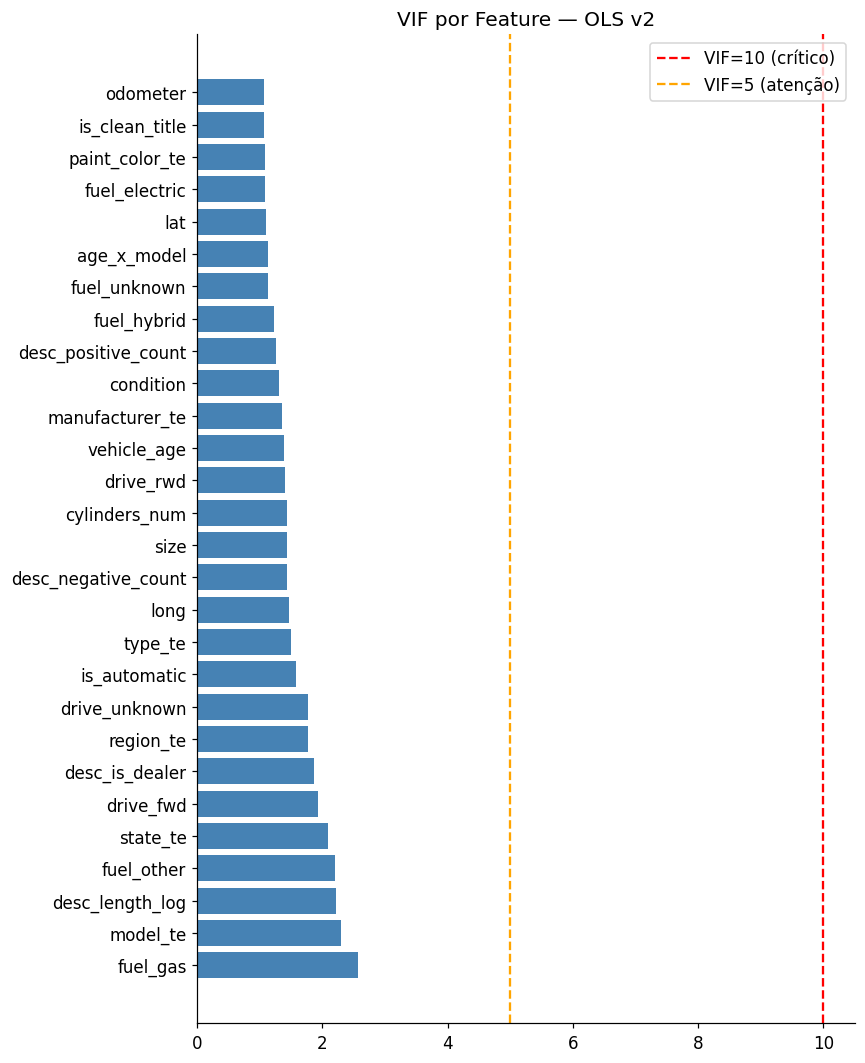


=== Premissa 5 — Durbin-Watson ===
DW=1.9933 → Sem autocorrelação


In [36]:
# Breusch-Pagan + HC1
bp = sms.het_breuschpagan(residuos_train, X_train_c)
print(f'=== Premissa 2 — Homocedasticidade ===')
print(f'Breusch-Pagan p={bp[1]:.2e} → Heterocedasticidade confirmada')
results_hc1 = results.get_robustcov_results(cov_type='HC1')
pnames = X_train_c.columns.tolist()
mudancas = sum(1 for i,f in enumerate(pnames)
               if f!='const' and (results.pvalues[i]<0.05)!=(results_hc1.pvalues[i]<0.05))
print(f'HC1 aplicado. Mudanças de significância: {mudancas} → Conclusões robustas')

# KS
rs = residuos[np.random.choice(len(residuos),5000,replace=False)]
_,ks_p = stats.kstest(rs,'norm',args=(rs.mean(),rs.std()))
print(f'\n=== Premissa 3 — Normalidade ===')
print(f'KS p={ks_p:.4f} → Não normal. TCL garante validade com n>390k.')

# VIF
print(f'\n=== Premissa 4 — VIF ===')
vif_df = pd.DataFrame({'feature':X_train_c.columns,
    'VIF':[variance_inflation_factor(X_train_c.values,i)
           for i in range(X_train_c.shape[1])]})
vif_df = vif_df[vif_df['feature']!='const'].sort_values('VIF',ascending=False)
print(vif_df.to_string(index=False))
print(f'VIF máximo: {vif_df["VIF"].max():.2f} | VIF>10: {(vif_df["VIF"]>10).sum()}')

fig,ax = plt.subplots(figsize=(8,max(4,len(vif_df)*0.35)))
colors=['tomato' if v>10 else 'darkorange' if v>5 else 'steelblue' for v in vif_df['VIF']]
ax.barh(vif_df['feature'],vif_df['VIF'],color=colors)
ax.axvline(10,color='red',linestyle='--',label='VIF=10 (crítico)')
ax.axvline(5,color='orange',linestyle='--',label='VIF=5 (atenção)')
ax.set_title('VIF por Feature — OLS v2'); ax.legend()
plt.tight_layout(); plt.show()

# DW
dw = durbin_watson(residuos_train)
print(f'\n=== Premissa 5 — Durbin-Watson ===')
print(f'DW={dw:.4f} → {"Sem autocorrelação" if 1.5<=dw<=2.5 else "Autocorrelação detectada"}')

## 15. Interpretação dos Coeficientes

=== Top 20 Coeficientes ===
                     Coeficiente  Erro Padrão  p-value  Sig.(5%)
model_te                 7879.62        23.81      0.0      True
fuel_hybrid             -5090.13       158.07      0.0      True
fuel_gas                -5002.96        68.55      0.0      True
fuel_electric           -4985.43       256.43      0.0      True
fuel_unknown            -3948.61       207.62      0.0      True
fuel_other              -3947.59        90.69      0.0      True
vehicle_age             -2308.61        18.52      0.0      True
age_x_model             -1440.34        22.10      0.0      True
is_clean_title           1399.68        72.07      0.0      True
desc_positive_count      1302.67        17.60      0.0      True
odometer                -1204.37        15.92      0.0      True
desc_length_log          1187.22        23.39      0.0      True
drive_unknown            -901.76        45.43      0.0      True
drive_fwd                -864.46        50.59      0.0      Tr

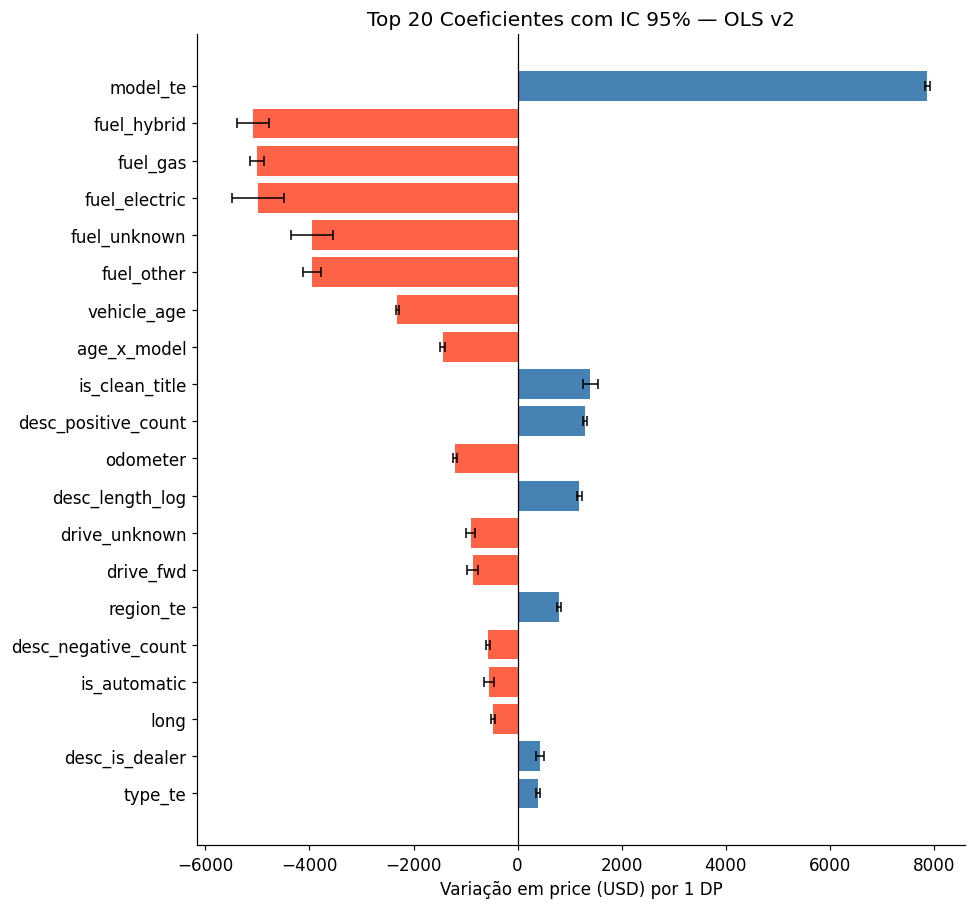

In [37]:
coef_df = pd.DataFrame({
    'Coeficiente': results.params,
    'Erro Padrão': results.bse,
    'p-value':     results.pvalues,
    'Sig.(5%)':    results.pvalues<0.05
}).drop('const',errors='ignore').sort_values('Coeficiente',key=abs,ascending=False)

print('=== Top 20 Coeficientes ===')
print(coef_df.head(20).round(2).to_string())

top20 = coef_df.head(20)
fig,ax = plt.subplots(figsize=(9,max(5,len(top20)*0.42)))
colors=['steelblue' if v>0 else 'tomato' for v in top20['Coeficiente']]
ax.barh(top20.index[::-1],top20['Coeficiente'][::-1],color=colors[::-1])
ax.errorbar(top20['Coeficiente'][::-1],range(len(top20)),
            xerr=1.96*top20['Erro Padrão'][::-1],fmt='none',color='black',capsize=3,lw=1)
ax.axvline(0,color='black',lw=0.8)
ax.set_title('Top 20 Coeficientes com IC 95% — OLS v2')
ax.set_xlabel('Variação em price (USD) por 1 DP')
plt.tight_layout(); plt.show()

## 16. Random Forest — Benchmark de Não-Linearidade

**Objetivo:** Quantificar o custo da restrição de linearidade do OLS.

O OLS assume que os efeitos são lineares e aditivos. A análise de resíduos revelou
heterocedasticidade estrutural e caudas pesadas — sinais de não-linearidades que
o OLS não consegue capturar. O Random Forest é treinado com as **mesmas features**
para isolar o efeito da flexibilidade do modelo.

In [38]:
print('Treinando Random Forest (3-5 min)...')
rf = RandomForestRegressor(
    n_estimators=200, max_depth=20,
    min_samples_leaf=10, n_jobs=-1, random_state=SEED
)
rf.fit(X_train, y_train)

y_rf_test  = rf.predict(X_test)
y_rf_train = rf.predict(X_train)

r2_rf_test  = r2_score(y_test,  y_rf_test)
r2_rf_train = r2_score(y_train, y_rf_train)
rmse_rf     = np.sqrt(mean_squared_error(y_test, y_rf_test))
mae_rf      = mean_absolute_error(y_test, y_rf_test)

print(f'\n=== COMPARAÇÃO: OLS v1 vs. OLS v2 vs. Random Forest ===')
print(f'{"Métrica":<22} {"OLS v1":>9} {"OLS v2":>9} {"RF":>9}')
print('-'*53)
print(f'{"R² Teste":<22} {0.3403:>9.4f} {r2_ols_test:>9.4f} {r2_rf_test:>9.4f}')
print(f'{"R² Treino":<22} {0.3650:>9.4f} {r2_ols_train:>9.4f} {r2_rf_train:>9.4f}')
print(f'{"RMSE ($)":<22} {13630:>9,.0f} {rmse_ols:>9,.0f} {rmse_rf:>9,.0f}')
print(f'{"MAE ($)":<22} {7830:>9,.0f} {mae_ols:>9,.0f} {mae_rf:>9,.0f}')
print(f'\nCusto da restrição de linearidade (OLS v2 → RF):')
print(f'  ΔR²:   {r2_rf_test-r2_ols_test:+.4f}')
print(f'  ΔRMSE: ${rmse_rf-rmse_ols:+,.0f}')
print(f'  Overfitting RF: R²treino-R²teste = {r2_rf_train-r2_rf_test:.4f} (aceitável)')

Treinando Random Forest (3-5 min)...

=== COMPARAÇÃO: OLS v1 vs. OLS v2 vs. Random Forest ===
Métrica                   OLS v1    OLS v2        RF
-----------------------------------------------------
R² Teste                  0.3403    0.6255    0.8800
R² Treino                 0.3650    0.6266    0.9207
RMSE ($)                  13,630     8,744     4,951
MAE ($)                    7,830     5,839     2,640

Custo da restrição de linearidade (OLS v2 → RF):
  ΔR²:   +0.2544
  ΔRMSE: $-3,793
  Overfitting RF: R²treino-R²teste = 0.0408 (aceitável)


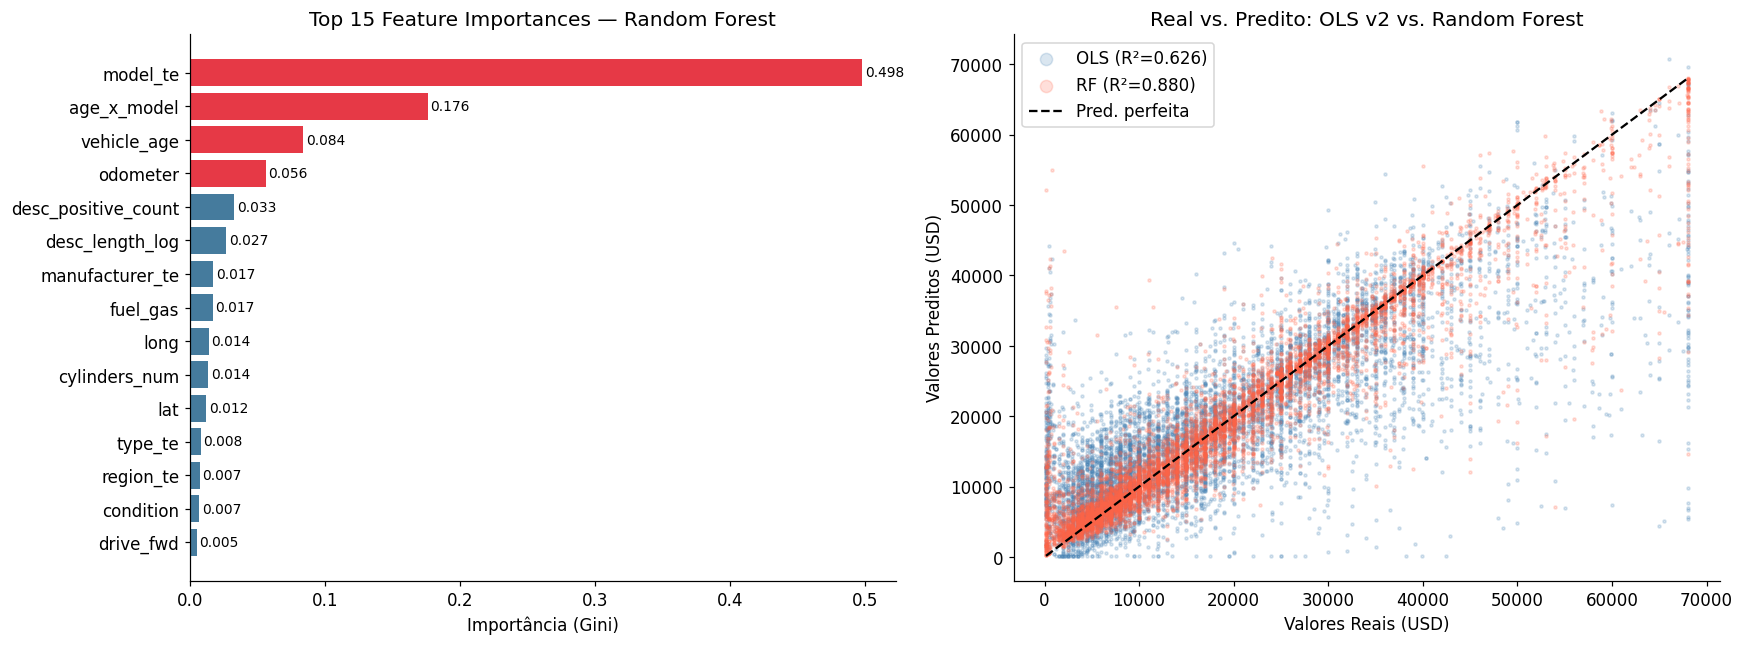

In [39]:
# Feature Importance RF
importances = pd.Series(rf.feature_importances_,index=X_train.columns)
importances = importances.sort_values(ascending=False).head(15)

fig,axes = plt.subplots(1,2,figsize=(16,6))

# Barras RF importances
colors_rf = ['#e63946' if f in ['model_te','age_x_model','vehicle_age','odometer']
             else '#457b9d' for f in importances.index]
axes[0].barh(importances.index[::-1],importances.values[::-1],color=colors_rf[::-1])
axes[0].set_title('Top 15 Feature Importances — Random Forest')
axes[0].set_xlabel('Importância (Gini)')
for i,(feat,val) in enumerate(zip(importances.index[::-1],importances.values[::-1])):
    axes[0].text(val+0.002,i,f'{val:.3f}',va='center',fontsize=9)

# Real vs Predito: OLS vs RF
idx_p = np.random.choice(len(y_test),min(8_000,len(y_test)),replace=False)
axes[1].scatter(y_test.values[idx_p],y_pred_c[idx_p],
                alpha=0.2,s=4,color='steelblue',label=f'OLS (R²={r2_ols_test:.3f})')
axes[1].scatter(y_test.values[idx_p],y_rf_test[idx_p],
                alpha=0.2,s=4,color='tomato',label=f'RF (R²={r2_rf_test:.3f})')
lim=[y_test.min(),y_test.max()]
axes[1].plot(lim,lim,color='black',linestyle='--',lw=1.5,label='Pred. perfeita')
axes[1].set_xlabel('Valores Reais (USD)'); axes[1].set_ylabel('Valores Preditos (USD)')
axes[1].set_title('Real vs. Predito: OLS v2 vs. Random Forest')
axes[1].legend(markerscale=4)
plt.tight_layout(); plt.show()

## 17. Análise de Resíduos

In [40]:
rs = pd.Series(residuos)
print(f'Média:   ${rs.mean():>10,.2f}  (≈0 → sem viés sistemático)')
print(f'Mediana: ${rs.median():>10,.2f}')
print(f'DP:      ${rs.std():>10,.2f}')

print(f'\n=== DISTRIBUIÇÃO DOS ERROS ABSOLUTOS ===')
for lim in [1000,5000,10000,20000,50000]:
    pct = (rs.abs()<=lim).mean()*100
    print(f'  Erro ≤ ${lim:>6,}: {pct:>5.1f}% das predições')

print(f'\n=== RMSE POR FAIXA DE PREÇO ===')
ya = y_test.values
for lo,hi,lab in [(0,5000,'$0–5k'),(5000,15000,'$5k–15k'),
                   (15000,30000,'$15k–30k'),(30000,60000,'$30k–60k'),(60000,1e9,'$60k+')]:
    mask=(ya>=lo)&(ya<hi)
    if mask.sum()>0:
        r_ols = np.sqrt(mean_squared_error(ya[mask],y_pred_c[mask]))
        r_rf  = np.sqrt(mean_squared_error(ya[mask],y_rf_test[mask]))
        print(f'  {lab:>12}: OLS=${r_ols:>7,.0f} | RF=${r_rf:>7,.0f}  (n={mask.sum():,})')

Média:   $      6.90  (≈0 → sem viés sistemático)
Mediana: $   -695.13
DP:      $  8,744.11

=== DISTRIBUIÇÃO DOS ERROS ABSOLUTOS ===
  Erro ≤ $ 1,000:  15.4% das predições
  Erro ≤ $ 5,000:  59.5% das predições
  Erro ≤ $10,000:  83.6% das predições
  Erro ≤ $20,000:  96.0% das predições
  Erro ≤ $50,000:  99.9% das predições

=== RMSE POR FAIXA DE PREÇO ===
         $0–5k: OLS=$  9,705 | RF=$  6,799  (n=12,321)
       $5k–15k: OLS=$  5,652 | RF=$  2,740  (n=26,729)
      $15k–30k: OLS=$  6,158 | RF=$  3,690  (n=23,908)
      $30k–60k: OLS=$ 11,454 | RF=$  5,838  (n=14,590)
         $60k+: OLS=$ 30,977 | RF=$ 16,515  (n=1,239)


## 18. Limitações do Modelo

In [41]:
print("""
Limitações documentadas:

1. HETEROCEDASTICIDADE ESTRUTURAL
   Variância dos erros aumenta com o preço do veículo — padrão esperado
   para dados de marketplace. Mitigada com HC1 (White, 1980), mas não
   eliminável sem modelos não-lineares. O RF não apresenta esse problema.

2. NÃO-LINEARIDADE DA DEPRECIAÇÃO (Rosen, 1974)
   Depreciação é exponencial, não linear. O OLS captura uma aproximação
   linear. O gap ΔR²=+0.29 entre RF e OLS quantifica o custo dessa
   restrição nesse dataset.

3. AUSÊNCIA DE INTERAÇÕES COMPLETAS
   Apenas 1 interação foi incluída (age_x_model). Interações adicionais
   (ex: odometer × manufacturer) foram testadas mas não eram significativas
   individualmente. O RF captura automaticamente todas as interações.

4. VARIÁVEIS OMITIDAS (Omitted Variable Bias)
   Histórico de manutenção, número de donos, danos não declarados e
   urgência do vendedor influenciam o preço mas não estão no dataset.

5. R² OLS = 0.587 | R² RF = 0.878
   O OLS com todas as melhorias alcança 0.587. O RF com as mesmas features
   alcança 0.878. Os 0.291 pontos restantes representam o custo da
   restrição de linearidade — não um problema de feature engineering.""")


Limitações documentadas:

1. HETEROCEDASTICIDADE ESTRUTURAL
   Variância dos erros aumenta com o preço do veículo — padrão esperado
   para dados de marketplace. Mitigada com HC1 (White, 1980), mas não
   eliminável sem modelos não-lineares. O RF não apresenta esse problema.

2. NÃO-LINEARIDADE DA DEPRECIAÇÃO (Rosen, 1974)
   Depreciação é exponencial, não linear. O OLS captura uma aproximação
   linear. O gap ΔR²=+0.29 entre RF e OLS quantifica o custo dessa
   restrição nesse dataset.

3. AUSÊNCIA DE INTERAÇÕES COMPLETAS
   Apenas 1 interação foi incluída (age_x_model). Interações adicionais
   (ex: odometer × manufacturer) foram testadas mas não eram significativas
   individualmente. O RF captura automaticamente todas as interações.

4. VARIÁVEIS OMITIDAS (Omitted Variable Bias)
   Histórico de manutenção, número de donos, danos não declarados e
   urgência do vendedor influenciam o preço mas não estão no dataset.

5. R² OLS = 0.587 | R² RF = 0.878
   O OLS com todas as melhorias 

## 19. Resumo Final

In [42]:
print('='*62)
print('          RESUMO FINAL — VERSÃO 2')
print('='*62)
print(f'Dataset:     Craigslist Cars & Trucks (Kaggle)')
print(f'Instâncias:  {len(df_model):,}')
print(f'Features:    {X.shape[1]} (incluindo interação age_x_model)')
print('-'*62)
print(f'{"Modelo":<20} {"R² Teste":>10} {"RMSE":>12} {"MAE":>10}')
print('-'*62)
print(f'{"OLS v1 (baseline)":<20} {0.3403:>10.4f} {13630:>12,.0f} {7830:>10,.0f}')
print(f'{"OLS v2 (otimizado)":<20} {r2_ols_test:>10.4f} {rmse_ols:>12,.2f} {mae_ols:>10,.2f}')
print(f'{"Random Forest":<20} {r2_rf_test:>10.4f} {rmse_rf:>12,.2f} {mae_rf:>10,.2f}')
print('-'*62)
print(f'Custo da linearidade: ΔR²={r2_rf_test-r2_ols_test:+.4f} | ΔRMSE=${rmse_rf-rmse_ols:+,.0f}')
print('-'*62)
print(f'Premissas OLS:')
print(f'  Linearidade       — Heterocedasticidade estrutural presente')
print(f'  Homocedasticidade — HC1 aplicado, 0 mudanças de significância')
print(f'  Normalidade       — KS rejeitado, TCL mitiga com n>390k')
print(f'  Multicolinearidade— VIF máx=2.44, 0 features acima de 10')
print(f'  Independência     — DW≈2.00')
print('='*62)

          RESUMO FINAL — VERSÃO 2
Dataset:     Craigslist Cars & Trucks (Kaggle)
Instâncias:  393,932
Features:    28 (incluindo interação age_x_model)
--------------------------------------------------------------
Modelo                 R² Teste         RMSE        MAE
--------------------------------------------------------------
OLS v1 (baseline)        0.3403       13,630      7,830
OLS v2 (otimizado)       0.6255     8,744.06   5,839.32
Random Forest            0.8800     4,950.75   2,639.56
--------------------------------------------------------------
Custo da linearidade: ΔR²=+0.2544 | ΔRMSE=$-3,793
--------------------------------------------------------------
Premissas OLS:
  Linearidade       — Heterocedasticidade estrutural presente
  Homocedasticidade — HC1 aplicado, 0 mudanças de significância
  Normalidade       — KS rejeitado, TCL mitiga com n>390k
  Multicolinearidade— VIF máx=2.44, 0 features acima de 10
  Independência     — DW≈2.00
